# Determining statistics per gene
This code determines statistics based on the results obtained in the _pergene.txt file by the Matlab code provided by Benoit.
This file consists of three columns.
The rows in the first column contains all genes of * S.Cerevisiae*, the corresponding transposon count is stored in the second column and the third column contains the reads.


The genes in this file are split into two groups based on their essentiality.
This is determined using two files that contains all known essential genes.


The data is represented as a violinplot where both the essential and non-essential genes are shown.

## Initialization

Data that needs to be loaded:

1. Path and filename of the results obtained by the Matlab code of benoit.
2. File(s) that include a list of all known essential genes (in WT).
3. File with gene information, most notably, the length of each gene and both the standard name and the systematic name. 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Input variables

1. normalize: Whether or not to normalize the transposon and read counts to the gene lengths (True or False)
2. filepath: Path to the output text file the Matlab code of Benoit that includes the read and transposon count per gene (with extension ...pergene.txt)
3. filename: Name of this file.
4. essential_genes_files: List of essential genes. Can be input as multiple files which will be automatically merged.
5. gene_information_file: List of genes with their possible aliasses and lengths in amino acids.

In [7]:
#'/Users/gregory/Documents/LaanLab/LaanLab_Data/Michel2017_WT1/'
#'Cerevisiae_WT1_Michel2017_Trimmed_Aligned.sorted.bam_pergene.txt')
#'E-MTAB-4885.WT1.bam_pergene.txt')
filepath = '/Users/gregory/Documents/LaanLab/LaanLab_Data/Michel2017_WT1/'
filename = 'Cerevisiae_WT1_Michel2017_Trimmed_Aligned.sorted.bam_pergene.txt'
normalize = 'True'

essential_genes_files = ['/Users/gregory/Documents/LaanLab/EssentialGenes_Database/Cervisiae_EssentialGenes_List_1.txt',
                        '/Users/gregory/Documents/LaanLab/EssentialGenes_Database/Cervisiae_EssentialGenes_List_2.txt']

gene_information_file = '/Users/gregory/Documents/LaanLab/EssentialGenes_Database/Yeast_Protein_Names.txt'

## Make list of all essential genes.
This can be input from multiple files that are merged in one list.

In [4]:
known_essential_gene_list = []

for files in essential_genes_files:
    with open(files) as f:
        for header_lines in range(3):
            next(f)
        for lines in f:
            known_essential_gene_list.append(lines.rstrip('\n'))

## Create a dictionary with length all genes
Dictionary consists of keys which are all genes (including all their potential aliasses) and of values which are the length in terms of base pairs.
The number of base pairs is calculated by multiplying the number of amino acids by 3.


In [5]:
gene_length_dict = {}

with open(gene_information_file) as f:
    lines = f.readlines()
    for i in range(58,len(lines)-6):
        n=0
        l = lines[i]

        extra_columns = l.count(';')    #count how many times ';' occurs in a line. This is needed to get the right columns as sometimes aliases of gene names are presented in extra columns
        l_short = ' '.join(l.split())
        l_list = l_short.split(' ')

        if l_list[1+extra_columns] == 'GAG' or l_list[1+extra_columns] == 'POL':    #these are sequences that sometimes occurs and have to be ignored
            extra_columns = extra_columns + 1

        gene_length_dict[l_list[0].strip(';')] = int(l_list[5+extra_columns])*3
        gene_length_dict[l_list[1+extra_columns]] = int(l_list[5+extra_columns])*3

        if extra_columns > 0:
            for n in range(extra_columns+1):
                gene_length_dict[l_list[0+n]] = int(l_list[5+extra_columns])*3

## Create lists with information to be plotted
Lists are made for

1. Gene names
2. Reads per gene 
3. Transposons per gene 
4. Whether or not a gene is essential or not (contains only True and False statements)
5. Reads per gene normalized to the length of each gene in terms of base pairs
6. Transposons per gene normalized to the length of each gene in terms of base pairs

The gene_counter counts the number of genes included in the analysis. The fail_counter are the number of genes that are present in the data, but could be found in the list of gene lengths and could therefore not be normalized. Therefore these are ignored. This should not be much more than 0.5% of the total amount of genes.

In [8]:
gene_name_list = []
reads_pergene_list = []
tn_pergene_list = []
gene_essential_boolean_list = []
reads_pergene_norm_list = []
tn_pergene_norm_list = []

file = os.path.join(filepath,filename)

with open(file) as f:
    next(f)
    gene_counter = 0
    fail_counter = 0
    for lines in f:
        split_line = lines.split('\t')

        gene_name = split_line[0].rstrip()



        if len(split_line) > 1:
            tn_pergene = int(split_line[1])
        else:
            tn_pergene = np.nan

        if len(split_line) > 2:
            reads_pergene = int(split_line[2])
        else:
            reads_pergene = np.nan

        reads_pergene_list.append(reads_pergene)
        tn_pergene_list.append(tn_pergene)


        if normalize == 'False':
            if gene_name in known_essential_gene_list:
                gene_essential_boolean_list.append('True') 
            else:
                gene_essential_boolean_list.append('False')
            gene_name_list.append(gene_name)

        else:
            gene_length = gene_length_dict.get(gene_name)
            try:
                reads_pergene_norm_list.append(reads_pergene/gene_length)
                tn_pergene_norm_list.append(tn_pergene/gene_length)

                if gene_name in known_essential_gene_list:
                    gene_essential_boolean_list.append('True') 
                else:
                    gene_essential_boolean_list.append('False')

                gene_name_list.append(gene_name)
                gene_counter = gene_counter + 1
            except:
                fail_counter = fail_counter + 1

print('Number of genes analyzed: ',gene_counter)
print('Number of genes not found: ',fail_counter)

Number of genes analyzed:  6586
Number of genes not found:  17


## Create dataframe
This puts the data in the form of a dataframe (part of the pandas package). This is necessary for plotting.

In [9]:
if normalize == 'False':
    genes = {'Gene_name': gene_name_list,
            'Transposons_per_gene': tn_pergene_list,
            'Reads_per_gene': reads_pergene_list,
            'Essential_gene': gene_essential_boolean_list
            }
else:
    genes = {'Gene_name': gene_name_list,
            'Transposons_per_gene': tn_pergene_norm_list,
            'Reads_per_gene': reads_pergene_norm_list,
            'Essential_gene': gene_essential_boolean_list
            }
df = pd.DataFrame(genes,columns=['Gene_name','Transposons_per_gene','Reads_per_gene', 'Essential_gene'])

## Print statistics

In [10]:
print('Average number of reads all genes: ',np.nanmean(reads_pergene_list))
print('Median number of reads all genes: ',np.nanmedian(reads_pergene_list))
print('Standard Deviation number of reads all genes: ',np.nanstd(reads_pergene_list))
print('')

print('Average number of transposons all genes: ',np.nanmean(tn_pergene_list))
print('Median number of transposons all genes: ',np.nanmedian(tn_pergene_list))
print('Standard Deviation number of transposons all genes: ',np.nanstd(tn_pergene_list))
print('')
print('')



indices_essential_genes_list = [i for i, x in enumerate(gene_essential_boolean_list) if x == 'True']
reads_peressentialgene_list = [reads_pergene_list[i] for i in indices_essential_genes_list]
print('Average number of reads of essential genes: ',np.nanmean(reads_peressentialgene_list))
print('Median number of reads of essential genes: ',np.nanmedian(reads_peressentialgene_list))
print('Maximum number of reads of essential genes: ',np.nanmax(reads_peressentialgene_list))
print('Minimum number of reads of essential genes: ',np.nanmin(reads_peressentialgene_list))
print('')

indices_nonessential_genes_list = [i for i, x in enumerate(gene_essential_boolean_list) if x == 'False']
reads_pernonessentialgene_list = [reads_pergene_list[i] for i in indices_nonessential_genes_list]
print('Average number of reads of nonessential genes: ',np.nanmean(reads_pernonessentialgene_list))
print('Median number of reads of nonessential genes: ',np.nanmedian(reads_pernonessentialgene_list))
print('Maximum number of reads of nonessential genes: ',np.nanmax(reads_pernonessentialgene_list))
print('Minimum number of reads of nonessential genes: ',np.nanmin(reads_pernonessentialgene_list))
print('')
print('')



tn_peressentialgene_list = [tn_pergene_list[i] for i in indices_essential_genes_list]
print('Average number of transposons of essential genes: ',np.nanmean(tn_peressentialgene_list))
print('Median number of transposons of essential genes: ',np.nanmedian(tn_peressentialgene_list))
print('Standard deviation number of transposons of essential genes: ',np.nanstd(tn_peressentialgene_list))
print('Maximum number of transposons of essential genes: ',np.nanmax(tn_peressentialgene_list))
print('Minimum number of transposons of essential genes: ',np.nanmin(tn_peressentialgene_list))
print('')

tn_pernonessentialgene_list = [tn_pergene_list[i] for i in indices_nonessential_genes_list]
print('Average number of transposons of nonessential genes: ',np.nanmean(tn_pernonessentialgene_list))
print('Median number of transposons of nonessential genes: ',np.nanmedian(tn_pernonessentialgene_list))
print('Standard deviation number of transposons of nonessential genes: ',np.nanstd(tn_pernonessentialgene_list))
print('Maximum number of transposons of nonessential genes: ',np.nanmax(tn_pernonessentialgene_list))
print('Minimum number of transposons of nonessential genes: ',np.nanmin(tn_pernonessentialgene_list))
print('')

Average number of reads all genes:  1909.281491587085
Median number of reads all genes:  685.0
Standard Deviation number of reads all genes:  5186.7011057323

Average number of transposons all genes:  69.25966348340155
Median number of transposons all genes:  41.0
Standard Deviation number of transposons all genes:  92.01436492473108


Average number of reads of essential genes:  2284.9784110535406
Median number of reads of essential genes:  770.5
Maximum number of reads of essential genes:  83178
Minimum number of reads of essential genes:  0

Average number of reads of nonessential genes:  1827.5610475839173
Median number of reads of nonessential genes:  675.5
Maximum number of reads of nonessential genes:  81569.0
Minimum number of reads of nonessential genes:  0.0


Average number of transposons of essential genes:  76.50518134715026
Median number of transposons of essential genes:  44.5
Standard deviation number of transposons of essential genes:  101.71609320735733
Maximum number

## Plot a violin plot
When normalization is set to True, the plots represent read- and transposon densities.

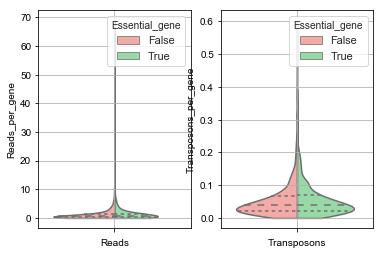

In [11]:
#     n_reads,bins_reads,patches_reads = plt.hist(reads_pergene_list, bins=100,facecolor='blue',alpha=0.3, label='Reads')
#     n_tn,bins_tn,patches_tn = plt.hist(tn_pergene_list, facecolor='red',alpha=0.5, label='Transposons')
#     plt.scattter(reads,_pergene)
#     plt.legend()
#     plt.xlabel('Counts per gene')
#     plt.ylabel('Occurance')
#     plt.grid()
#     plt.show()

fig, (ax1, ax2) = plt.subplots(1,2)
sns.set(style='whitegrid', palette='pastel', color_codes=True)
df['Reads'] = ''
sns.violinplot(x='Reads',y="Reads_per_gene", hue='Essential_gene', inner='quarter', gridsize=400, palette={'False':'r', 'True':'g'}, split=True, cut=0, data=df, ax=ax1)
ax1.grid()

df['Transposons'] = ''
sns.violinplot(x='Transposons',y="Transposons_per_gene", hue='Essential_gene', inner='quarter', gridsize=400, palette={'False':'r', 'True':'g'}, split=True, cut=0, data=df, ax=ax2)
ax2.grid()
plt.show()

## Conclusion

Ideally the median values of the essential and nonessential genes are far apart from each other, so that a clear distinction can be made between which genes are essential and which are not based on the transposon counts. If this is not the case or when there is significant overlap between the distribution, no definite conclusion can be drawn about the essentiality. This typically happens at the lower transposon density.